In [1]:
import numpy as np
import scipy.optimize as opt
import statistic_tools.general as st
import matplotlib.pyplot as plt
import inspect

In [2]:
def chi2cost(x0, f, xdata, ydata, yerr):
    return (f(xdata, *x0) - ydata)/yerr


def single_chi2_fit(ydata, idxs, estimator=None, args={}):
    xdata = args['xdata']
    func = args['func']
    yerr = args['yerr']
    
    best_of = args.get('best_of', 10)
    
    nargs = len(str(inspect.signature(func)).split(','))-1
    
    
    sol = opt.least_squares(chi2cost, np.ones((nargs,)), method='lm', 
                                args=(func, xdata[idxs], ydata[idxs], yerr[idxs]))
    chi2 = 2*sol.cost
    for i in range(best_of):
        x0 = np.random.uniform(0,10,size=nargs)
        sol_ = opt.least_squares(chi2cost, x0, method='lm', 
                                args=(func, xdata[idxs], ydata[idxs], yerr[idxs]))
        chi2_ = 2*sol_.cost
        if chi2_ < chi2:
            chi2 = chi2_
            sol = sol_
    
    param = list(sol.x) + [chi2]
    return param


def chi2_fitting(f, xdata, ydata, yerr=[], args0=[]):
    
    chi2args = {'xdata': xdata, 'yerr': yerr, 'func': f}
    
    
    
    vals, vals_err = st.bootstrap(ydata, sample_estimate_func=single_chi2_fit, estimator=None, 
                                  args=chi2args, withoriginal=True)
    
    popt = vals[:-1]
    perr = vals_err[:-1]
    chi2 = (vals[-1], vals_err[-1])
    return popt, perr, chi2
    




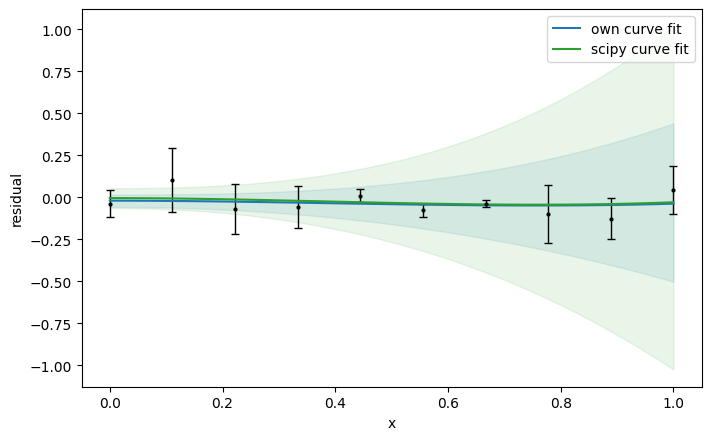

In [3]:
real_param = [2.1, 0.4, 0.5]

def f0(x, a, b, c):
    return a*(1+b*x**2+c*x**3)

def res(x, a, b, c):
    return f0(x, a, b, c) - f0(x, *real_param)

np.random.seed(42)




# Generate data
xdata = np.linspace(0, 1, 10)
yerr = np.random.uniform(0.01, 0.2, size=10)
ydata = f0(xdata, *real_param) + [np.random.normal(loc=0.0, scale=ye) for ye in yerr]
ydata_real = f0(xdata, *real_param)

x_ = np.linspace(0,1,100)
y_ = f0(x_, *real_param)


popt, perr, chi2 = chi2_fitting(f0, xdata, ydata, yerr=yerr)

popt_, pcov_ = opt.curve_fit(f0, xdata, ydata, sigma=yerr, absolute_sigma=True)
perr_ = np.sqrt(np.diag(pcov_))

popt_bad, pcov_bad = opt.curve_fit(f0, xdata, ydata, sigma=yerr)
perr_bad = np.sqrt(np.diag(pcov_bad))

plt.figure(dpi=100, figsize=(8,5))
plt.errorbar(xdata, ydata-ydata_real, yerr=yerr, marker='o', ms=2, lw=1, ls='', color='black', capsize=3)
#plt.plot(x_, y_, color='black', label='real curve')
plt.plot(x_, res(x_, *popt), color='tab:blue', label='own curve fit')
plt.fill_between(x_, res(x_, *(popt + perr)), res(x_, *(popt - perr)), alpha=0.1, color='tab:blue')

plt.plot(x_, res(x_, *popt_), color='tab:green', label='scipy curve fit')
plt.fill_between(x_, res(x_, *(popt_ + perr_)), res(x_, *(popt_ - perr_)), alpha=0.1, color='tab:green')

plt.ylabel('residual')
plt.xlabel('x')
plt.legend()
plt.show()